## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

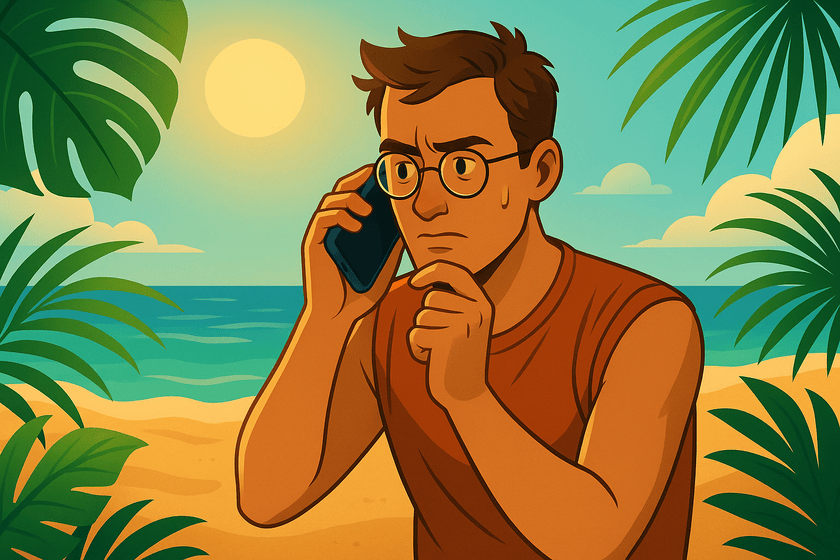

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


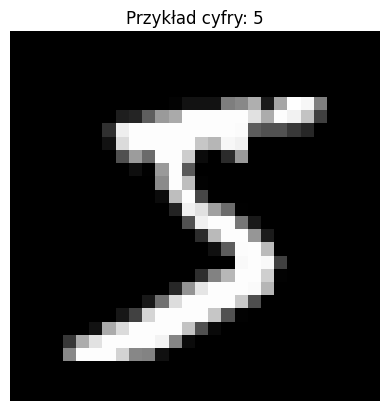

In [2]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

Importy

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
import pandas as pd

**Obliczenia statystyczne**
Wartości pikselów na obrazach w dataset MNIST mają wartości w zakresie [0,255]. Obliczam średnia (mean) oraz odchylenie standardowe (standard deviation).

In [6]:
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(x_train.min(), x_train.max()))
print('Mean Pixel Value: {} \nPixel Values Std: {}'.format(x_train.mean(), x_train.std()))
print('Scaled Mean Pixel Value: {} \nScaled Pixel Values Std: {}'.format(x_train.mean() / 255, x_train.std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value: 33.318421449829934 
Pixel Values Std: 78.56748998339798
Scaled Mean Pixel Value: 0.1306604762738429 
Scaled Pixel Values Std: 0.30810780385646264


Można założyć w przybliżeniu mean = 0.1307 oraz std = 0.3081

**Funkcja do testowania**

Nastepnie stworzyłam wygodną funkcję do testowania różnych sieci, modelów,paramtrów.
Parametry przekazywane jako argumenty do funkcji
- sieć wraz ze strukturą
- liczba epochów
- rozmiar batcha
- learning rate
- optimizer
- dropout rate
- device

Parametry ustawione domyślnie
-funkcja straty -> wybrałam CrossEntropyLoss jako iż mamy do czynienia z klasyfikacją wieloklasową

Funkcja zamienia dane wejściowe na tensory, a także dokonuje normlaizacji
Wykonuję trening, ewaluację, a także zbiera i zwraca wyniki oraz najważniejsze metryki.

In [27]:
def run_experiment(model_class,
                   n_epochs=5,
                   batch_size=64,
                   lr=0.01,
                   optimizer_name="adam",
                   dropout_rate=0.5,
                   device=None):

    # urządzenie
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # dane
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_loader = DataLoader(
        datasets.MNIST('./data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        datasets.MNIST('./data', train=False, download=True, transform=transform),
        batch_size=batch_size, shuffle=False
    )

    # model
    model = model_class(dropout_rate=dropout_rate).to(device)

    # optimizer
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Nieznany optimizer: wybierz 'adam', 'sgd' albo 'rmsprop'")

    # funkcja straty
    criterion = nn.CrossEntropyLoss()

   # listy do wyników
    train_losses, test_losses, accuracies = [], [], []
    precisions, recalls = [], []

    for epoch in range(1, n_epochs+1):
        # trening
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # ewaluacja
        model.eval()
        test_loss, correct = 0, 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        test_loss /= len(test_loader.dataset)
        acc = 100. * correct / len(test_loader.dataset)

        prec = precision_score(all_targets, all_preds, average="macro") * 100
        rec = recall_score(all_targets, all_preds, average="macro") * 100

        test_losses.append(test_loss)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)

        print(f"Epoch {epoch}/{n_epochs} | Test loss: {test_loss:.4f} | "
              f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}%")

    return model, train_losses, test_losses, accuracies, precisions, recalls

**Funkcja do wizualizacji wyników**

Funkcja, przyjmująca parametry zwracane przez funkcję do testowania i na tej podstawie wypisująca podstawową statystykę oraz tworząca wykresy porównania train loss i test loss, a także pokazująca jak zmieniało się Accuracy, Precision i Recall z każdym kolejnym epoch

In [28]:
def analyze_results(model, train_losses, test_losses, accuracies, precisions, recalls, params=None):
    if params is not None:
        print(" Parametry eksperymentu:")
        for k, v in params.items():
            print(f"   {k}: {v}")
    print("\n Wyniki końcowe:")
    print(f"   Train Loss: {train_losses[-1]:.4f}")
    print(f"   Test Loss:  {test_losses[-1]:.4f}")
    print(f"   Accuracy:   {accuracies[-1]:.2f}%")
    print(f"   Precision:  {precisions[-1]:.2f}%")
    print(f"   Recall:     {recalls[-1]:.2f}%")

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15,4))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Strata treningowa vs testowa")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, accuracies, marker="o", label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Dokładność na zbiorze testowym")
    plt.legend()

    # Precision & Recall
    plt.subplot(1,3,3)
    plt.plot(epochs, precisions, marker="x", label="Precision")
    plt.plot(epochs, recalls, marker="s", label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score (%)")
    plt.title("Precision & Recall")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n Struktura modelu:")
    print(model)


Najpierw przetestuję baseline - sieć liniową

In [29]:
class Baseline(nn.Module):
    def __init__(self,dropout_rate=0.0):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Epoch 1/3 | Test loss: 0.0017 | Accuracy: 96.62% | Precision: 96.63% | Recall: 96.60%
Epoch 2/3 | Test loss: 0.0014 | Accuracy: 97.15% | Precision: 97.17% | Recall: 97.13%
Epoch 3/3 | Test loss: 0.0011 | Accuracy: 97.86% | Precision: 97.84% | Recall: 97.85%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.2204
   Test Loss:  0.0011
   Accuracy:   97.86%
   Precision:  97.84%
   Recall:     97.85%


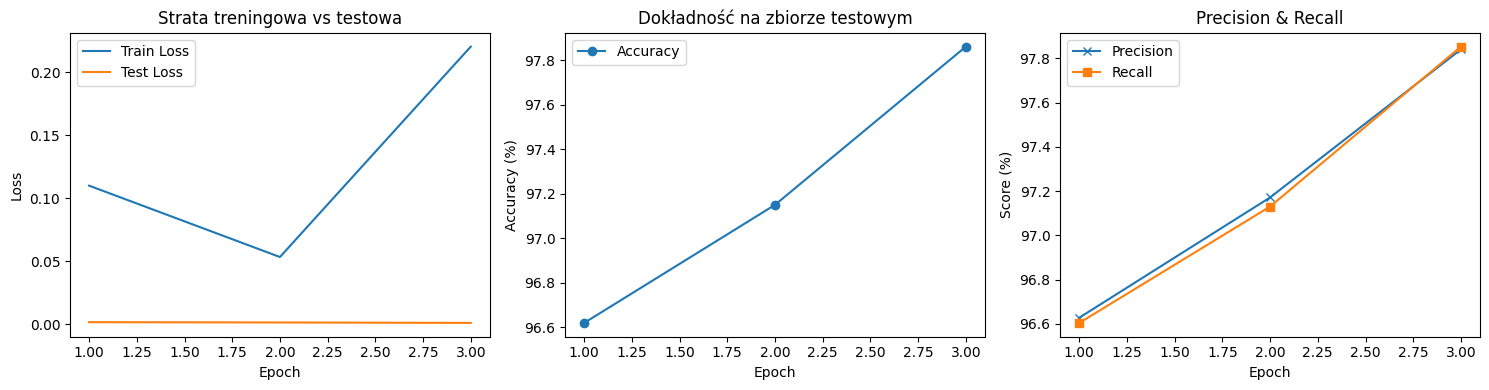


 Struktura modelu:
Baseline(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [30]:
params = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

model, train_losses, test_losses, accuracies, precisions, recalls = run_experiment(
    Baseline,
    **params
)

analyze_results(model, train_losses, test_losses, accuracies,precisions, recalls, params)

Jak widać już bazowa sieć radzi sobie z klasyfikacją bardzo dobrze, uzyskując wysokie wyniki we wszystkich metrykach. Wzrost Accuracy, Recall oraz Precision jest równomierny pomiedzy 1 a 2 oraz 2 a 3 epochem.

Teraz stworzę konwolucyjną sieć CNN
- 2 warstwy konowlucyjne
- 2 warstwy liniowe
- funkcja aktywacji -> RELU



In [31]:
class CNN1(nn.Module):
  def __init__(self, dropout_rate=0.5):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10 , kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20 , kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)
        self.fc1  = nn.Linear(320, 50)
        self.fc2  = nn.Linear(50, 10)

  def forward(self, x):
        x = self.conv1(x)

        #max pooling
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(x)

        x = self.conv2(x)

        x = F.max_pool2d(x, kernel_size=2)

        x=F.relu(x)

        #reshape i zmiana na warstwy liniowe
        x = x.view(-1,320)

        x = self.fc1(x)

        x = F.relu(x)

        x=F.dropout(x, training=self.training)

        x = self.fc2(x)
        return x

Pełny test pierwszej sieci

Epoch 1/3 | Test loss: 0.0013 | Accuracy: 97.41% | Precision: 97.44% | Recall: 97.40%
Epoch 2/3 | Test loss: 0.0008 | Accuracy: 98.40% | Precision: 98.40% | Recall: 98.39%
Epoch 3/3 | Test loss: 0.0006 | Accuracy: 98.74% | Precision: 98.73% | Recall: 98.73%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.0470
   Test Loss:  0.0006
   Accuracy:   98.74%
   Precision:  98.73%
   Recall:     98.73%


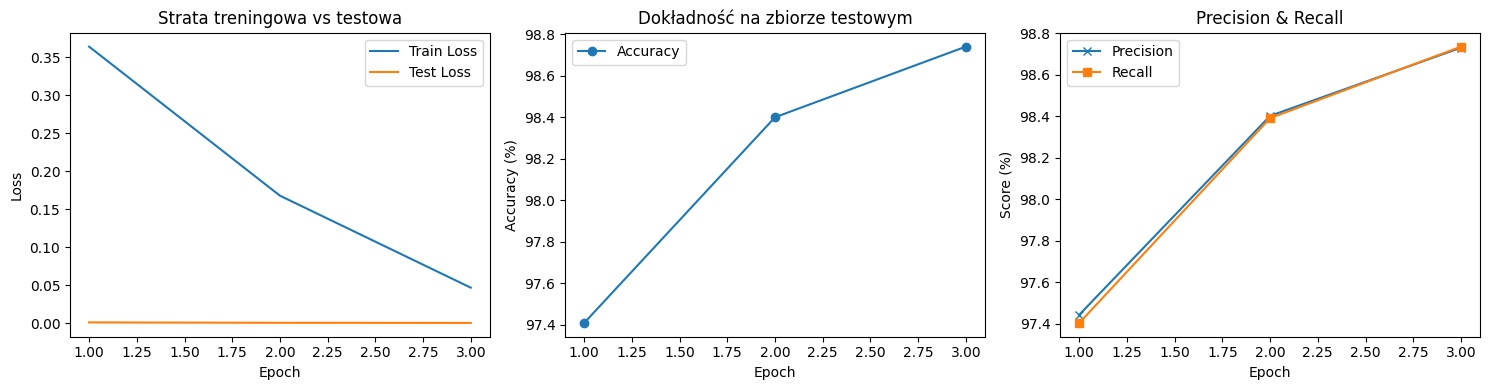


 Struktura modelu:
CNN1(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [32]:
params1 = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

model1, train_losses1, test_losses1, accuracies1,precisions1,recalls1 = run_experiment(
    CNN1,
    **params1
)

analyze_results(model1, train_losses1, test_losses1, accuracies1,precisions1,recalls1, params1)

Udało się uzyskać wyniki minimalnie wyższe niż dla sieci bazowej. Widać również , że wzrost wartości metryk występuję w większym stopniu pomiędzy 1 a 2 epochem. Train loss jest znacząco niższy niż przy Baseline

Teraz sprawdzę, jaki wpływ na wyniki ma szerokość i wysokość sieci. W tym celu przerobię model CNN, wszystkie inne parametry zpotawiając bez zmian

Zacznę od wersji węższej - mniej parametrów

In [33]:
class CNN2(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)
        self.fc1 = nn.Linear(192, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 192)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Epoch 1/3 | Test loss: 0.0017 | Accuracy: 96.59% | Precision: 96.63% | Recall: 96.55%
Epoch 2/3 | Test loss: 0.0011 | Accuracy: 97.77% | Precision: 97.76% | Recall: 97.75%
Epoch 3/3 | Test loss: 0.0009 | Accuracy: 98.08% | Precision: 98.09% | Recall: 98.05%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.0500
   Test Loss:  0.0009
   Accuracy:   98.08%
   Precision:  98.09%
   Recall:     98.05%


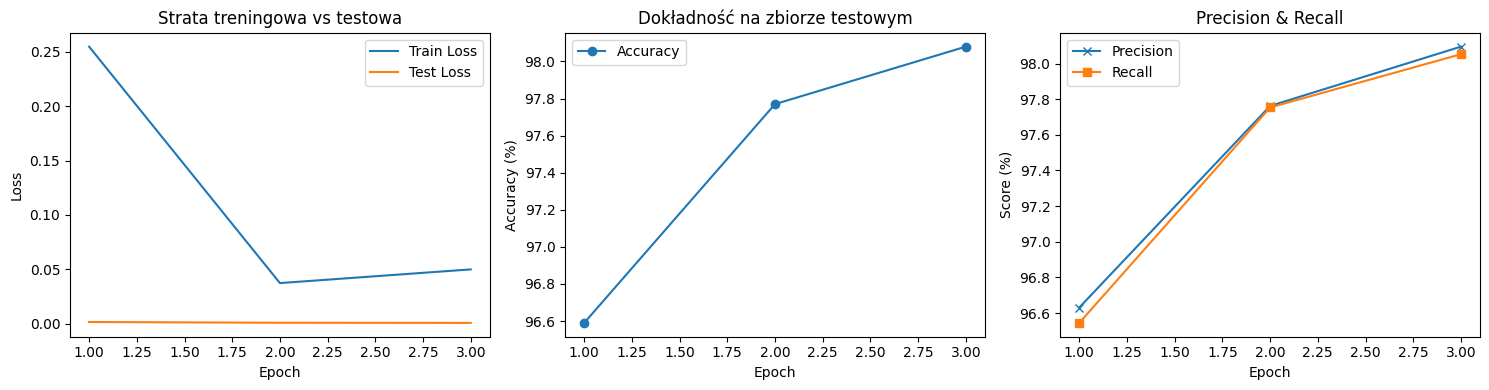


 Struktura modelu:
CNN2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=192, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


In [34]:
params2 = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

model2, train_losses2, test_losses2, accuracies2,precisions2,recalls2 = run_experiment(
    CNN2,
    **params2
)

analyze_results(model2, train_losses2, test_losses2, accuracies2,precisions2,recalls2, params2)

Jak widać, ta sieć również uzyskuję bardzo dobre wyniki we wszytskich metrykach. Można zauważyć, że są one minimalnie gorsze niż dla CNN1. Różnice widać również na wykresach, wzrost metryk przebiega inaczej. Widać, że zmniejszenie szerokości i wysokości sieci ma wpływ na wyniki, jednak w tym przypadku nie jest on duży.

Nastepnie sprawdzę wersję szerszą - większa liczba parametrów

In [35]:
class CNN3(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 40, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)
        self.fc1 = nn.Linear(640, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 640)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


Epoch 1/3 | Test loss: 0.0008 | Accuracy: 98.31% | Precision: 98.34% | Recall: 98.28%
Epoch 2/3 | Test loss: 0.0005 | Accuracy: 98.97% | Precision: 98.98% | Recall: 98.94%
Epoch 3/3 | Test loss: 0.0004 | Accuracy: 98.99% | Precision: 98.98% | Recall: 98.97%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.1798
   Test Loss:  0.0004
   Accuracy:   98.99%
   Precision:  98.98%
   Recall:     98.97%


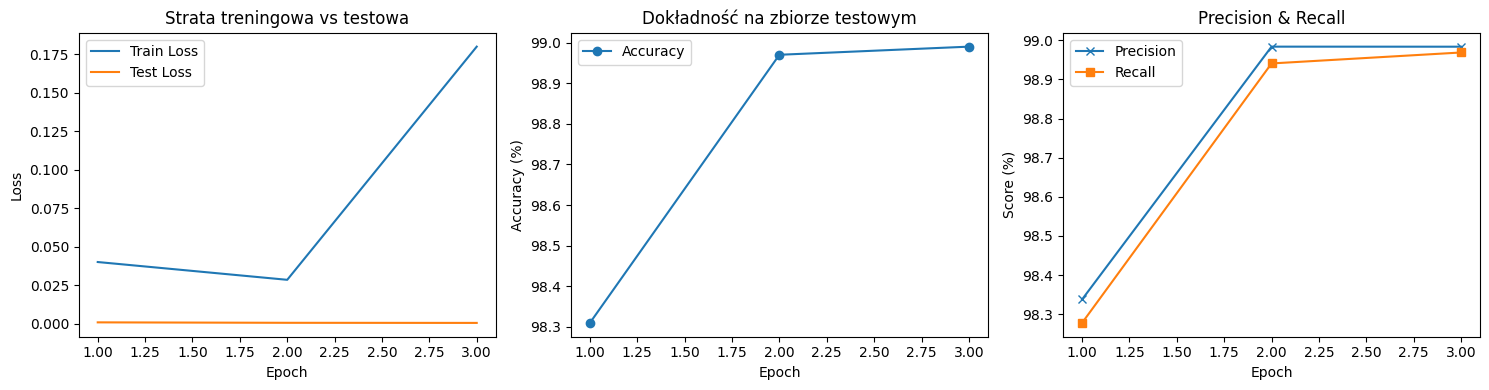


 Struktura modelu:
CNN3(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=640, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [36]:
params3 = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

model3, train_losses3, test_losses3, accuracies3,precisions3,recalls3 = run_experiment(
    CNN3,
    **params3
)

analyze_results(model3, train_losses3, test_losses3, accuracies3,precisions3,recalls3, params3)

Wyniki pokazują, iż przy takiej strukturze sieci, model bardzo szybko poprawia Accuracy, Recall oraz Precision pomiędzy 1 a 2 epochem, tak że pomiędzy 2 a 3 epochem , tak naprawdę metryki pozostają na tym samym poziomie. Dodatkowo model uzyskał w tej konfiguracji najniższe test loss do tej pory przy najwyższym train loss.

Na koniec przetestuję model w jeszcze szerszej wersji

In [37]:
class CNN4(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)
        self.fc1 = nn.Linear(1024, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


Epoch 1/3 | Test loss: 0.0006 | Accuracy: 98.80% | Precision: 98.80% | Recall: 98.79%
Epoch 2/3 | Test loss: 0.0005 | Accuracy: 98.94% | Precision: 98.95% | Recall: 98.93%
Epoch 3/3 | Test loss: 0.0003 | Accuracy: 99.24% | Precision: 99.23% | Recall: 99.24%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.0016
   Test Loss:  0.0003
   Accuracy:   99.24%
   Precision:  99.23%
   Recall:     99.24%


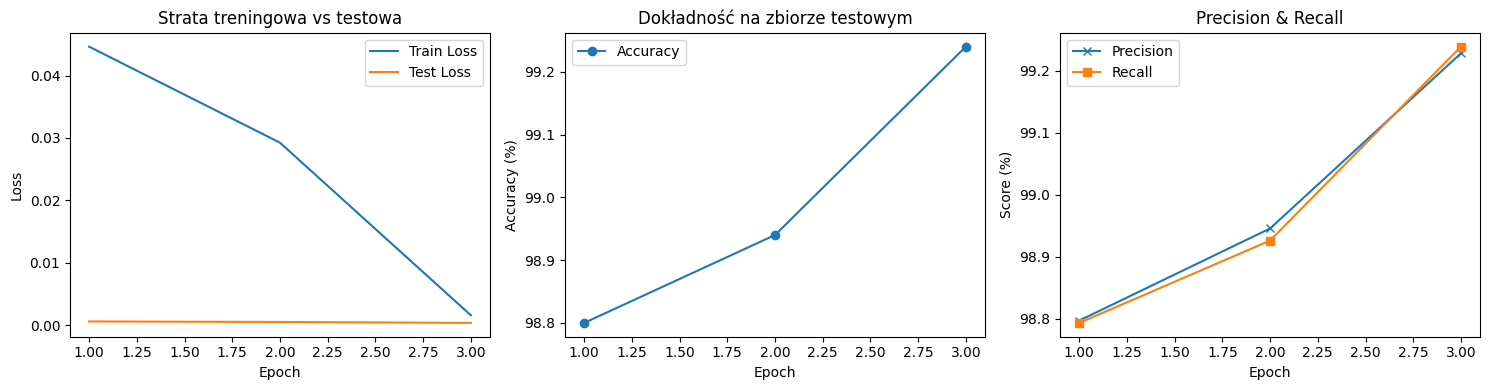


 Struktura modelu:
CNN4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)


In [38]:
params4 = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

model4, train_losses4, test_losses4, accuracies4,precisions4,recalls4 = run_experiment(
    CNN4,
    **params4
)

analyze_results(model4, train_losses4, test_losses4, accuracies4,precisions4,recalls4, params4)

Wizualizacja wyników tych 4 sieci, w kolejności od najwęższej do najszerszej

                   Model  Accuracy (%)  Precision (%)  Recall (%)  Train Loss  \
0           CNN2 (wąska)         96.59      96.631253   96.545057    0.254520   
1          CNN1 (bazowa)         97.41      97.442238   97.402859    0.364152   
2         CNN3 (szeroka)         98.31      98.337502   98.277568    0.039967   
3  CNN4 (bardzo szeroka)         98.80      98.796825   98.793054    0.044626   

   Test Loss  
0   0.001745  
1   0.001282  
2   0.000800  
3   0.000573  


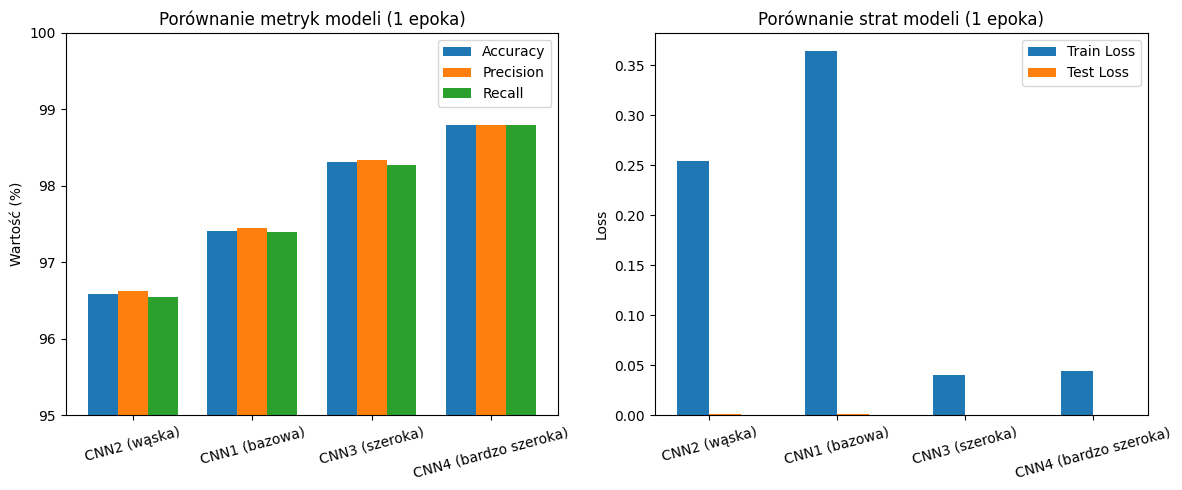

In [54]:
accs  = [accuracies2[0], accuracies1[0], accuracies3[0], accuracies4[0]]
precs = [precisions2[0], precisions1[0], precisions3[0], precisions4[0]]
recs  = [recalls2[0], recalls1[0], recalls3[0], recalls4[0]]
train_losses = [train_losses2[0], train_losses1[0], train_losses3[0], train_losses4[0]]
test_losses  = [test_losses2[0], test_losses1[0], test_losses3[0],test_losses4[0]]

model_names = ["CNN2 (wąska)", "CNN1 (bazowa)", "CNN3 (szeroka)", "CNN4 (bardzo szeroka)"]

df = pd.DataFrame({
    "Model": model_names,
    "Accuracy (%)": accs,
    "Precision (%)": precs,
    "Recall (%)": recs,
    "Train Loss": train_losses,
    "Test Loss": test_losses
})
print(df)

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(12,5))

#  Accuracy / Precision / Recall
plt.subplot(1,2,1)
plt.bar(x - width, accs, width, label="Accuracy")
plt.bar(x, precs, width, label="Precision")
plt.bar(x + width, recs, width, label="Recall")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Wartość (%)")
plt.title("Porównanie metryk modeli (1 epoka)")
plt.legend()
plt.ylim(95, 100)

#  Train vs Test Loss
plt.subplot(1,2,2)
plt.bar(x - width/2, train_losses, width, label="Train Loss")
plt.bar(x + width/2, test_losses, width, label="Test Loss")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Loss")
plt.title("Porównanie strat modeli (1 epoka)")
plt.legend()

plt.tight_layout()
plt.show()

Wraz ze wzrostem szerokości i wysokości zwiększa się precision, recall oraz accuracy, a także spada train i test loss

Teraz sprawdzę, czy i jak funkcja aktywacji wpływa na wyniki modelu. Zamiast funkcji relu dla modelu CNN1 użyję funkcji aktywacji warstwy wyjściowej - softmax. Zamienię również CrossEntropyLoss (która ma wbudowanego softmax) na funkcję straty NLLLoss

In [49]:
class CNNSoftmax(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNSoftmax, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [47]:
def run_experiment_with_softmax(model_class,
                   n_epochs=5,
                   batch_size=64,
                   lr=0.01,
                   optimizer_name="adam",
                   dropout_rate=0.5,
                   device=None):

    # urządzenie
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # dane
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_loader = DataLoader(
        datasets.MNIST('./data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        datasets.MNIST('./data', train=False, download=True, transform=transform),
        batch_size=batch_size, shuffle=False
    )

    # model
    model = model_class(dropout_rate=dropout_rate).to(device)

    # optimizer
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Nieznany optimizer: wybierz 'adam', 'sgd' albo 'rmsprop'")

    # funkcja straty
    criterion = nn.NLLLoss()

   # listy do wyników
    train_losses, test_losses, accuracies = [], [], []
    precisions, recalls = [], []

    for epoch in range(1, n_epochs+1):
        # trening
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # ewaluacja
        model.eval()
        test_loss, correct = 0, 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        test_loss /= len(test_loader.dataset)
        acc = 100. * correct / len(test_loader.dataset)

        prec = precision_score(all_targets, all_preds, average="macro") * 100
        rec = recall_score(all_targets, all_preds, average="macro") * 100

        test_losses.append(test_loss)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)

        print(f"Epoch {epoch}/{n_epochs} | Test loss: {test_loss:.4f} | "
              f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}%")

    return model, train_losses, test_losses, accuracies, precisions, recalls

Teraz przeprowadźmy test

Epoch 1/3 | Test loss: 0.0016 | Accuracy: 96.78% | Precision: 96.77% | Recall: 96.77%
Epoch 2/3 | Test loss: 0.0011 | Accuracy: 97.83% | Precision: 97.83% | Recall: 97.81%
Epoch 3/3 | Test loss: 0.0009 | Accuracy: 98.00% | Precision: 97.99% | Recall: 98.00%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.3188
   Test Loss:  0.0009
   Accuracy:   98.00%
   Precision:  97.99%
   Recall:     98.00%


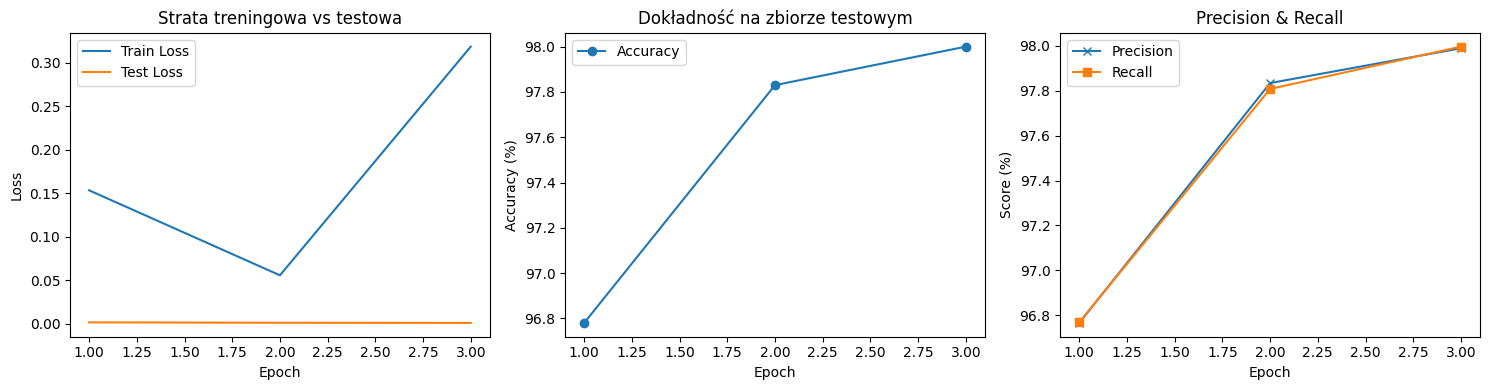


 Struktura modelu:
CNNSoftmax(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [50]:
paramsS = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

modelS, train_lossesS, test_lossesS, accuraciesS,precisionsS,recallsS = run_experiment_with_softmax(
    CNNSoftmax,
    **paramsS
)

analyze_results(modelS, train_lossesS, test_lossesS, accuraciesS,precisionsS,recallsS, paramsS)

Wizualizacja oraz porównanie

                               Model  Accuracy (%)  Precision (%)  Recall (%)  \
0   CNN1- CrossEntropyLoss oraz Relu         97.41      97.442238   97.402859   
1  CNNSoftmax - NLLLoss oraz Softmax         96.78      96.766750   96.769574   

   Train Loss  Test Loss  
0    0.364152   0.001282  
1    0.153483   0.001556  


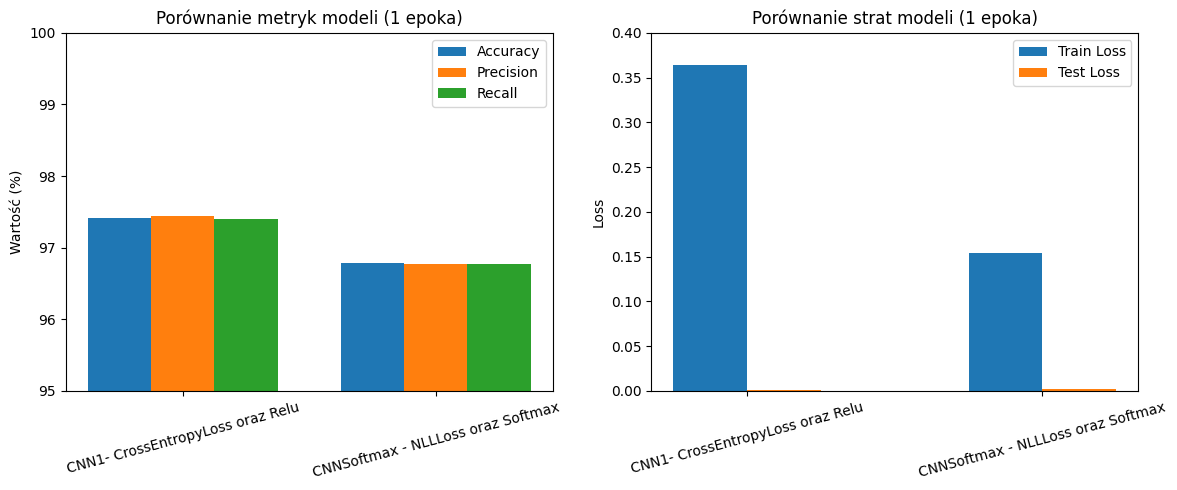

In [53]:
accs  = [accuracies1[0], accuraciesS[0]]
precs = [precisions1[0], precisionsS[0]]
recs  = [recalls1[0], recallsS[0]]
train_losses = [train_losses1[0], train_lossesS[0]]
test_losses  = [test_losses1[0], test_lossesS[0]]

model_names = ["CNN1- CrossEntropyLoss oraz Relu", "CNNSoftmax - NLLLoss oraz Softmax"]

df = pd.DataFrame({
    "Model": model_names,
    "Accuracy (%)": accs,
    "Precision (%)": precs,
    "Recall (%)": recs,
    "Train Loss": train_losses,
    "Test Loss": test_losses
})
print(df)

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(12,5))

#  Accuracy / Precision / Recall
plt.subplot(1,2,1)
plt.bar(x - width, accs, width, label="Accuracy")
plt.bar(x, precs, width, label="Precision")
plt.bar(x + width, recs, width, label="Recall")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Wartość (%)")
plt.title("Porównanie metryk modeli (1 epoka)")
plt.legend()
plt.ylim(95, 100)

#  Train vs Test Loss
plt.subplot(1,2,2)
plt.bar(x - width/2, train_losses, width, label="Train Loss")
plt.bar(x + width/2, test_losses, width, label="Test Loss")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Loss")
plt.title("Porównanie strat modeli (1 epoka)")
plt.legend()
plt.ylim(0.0, 0.40)

plt.tight_layout()
plt.show()

Można zauważyć, że model z funkcją straty CrossEntropyLoss oraz funkcją aktywacji Relu radzi sobie nieznacznie lepiej niż model z funkcją straty NLLLoss oraz funkcją aktywacji Softmax.

**Dropout**

Teraz sprawdzę jaki wpływ na wyniki modelu ma wartości parametru dropout, również zrobię to dla modelu CNN1. Żeby było szybciej, będę to robiła tylko dla 1 epochu.

In [55]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
results = {}

for dr in dropout_rates:
    print(f" Testowanie dla dropout_rate={dr}")
    model_d, train_losses_d, test_losses_d, accuracies_d, precisions_d, recalls_d = run_experiment(
        CNN1,
        n_epochs=1,
        batch_size=64,
        lr=0.001,
        optimizer_name="adam",
        dropout_rate=dr
    )
    results[dr] = {
        "train_loss": train_losses[-1],
        "test_loss": test_losses[-1],
        "accuracy": accuracies[-1],
        "precision": precisions[-1],
        "recall": recalls[-1]
    }

 Testowanie dla dropout_rate=0.1
Epoch 1/1 | Test loss: 0.0015 | Accuracy: 97.21% | Precision: 97.22% | Recall: 97.19%
 Testowanie dla dropout_rate=0.3
Epoch 1/1 | Test loss: 0.0012 | Accuracy: 97.50% | Precision: 97.51% | Recall: 97.48%
 Testowanie dla dropout_rate=0.5
Epoch 1/1 | Test loss: 0.0012 | Accuracy: 97.44% | Precision: 97.42% | Recall: 97.44%
 Testowanie dla dropout_rate=0.7
Epoch 1/1 | Test loss: 0.0012 | Accuracy: 97.69% | Precision: 97.69% | Recall: 97.69%


Wizualizacja

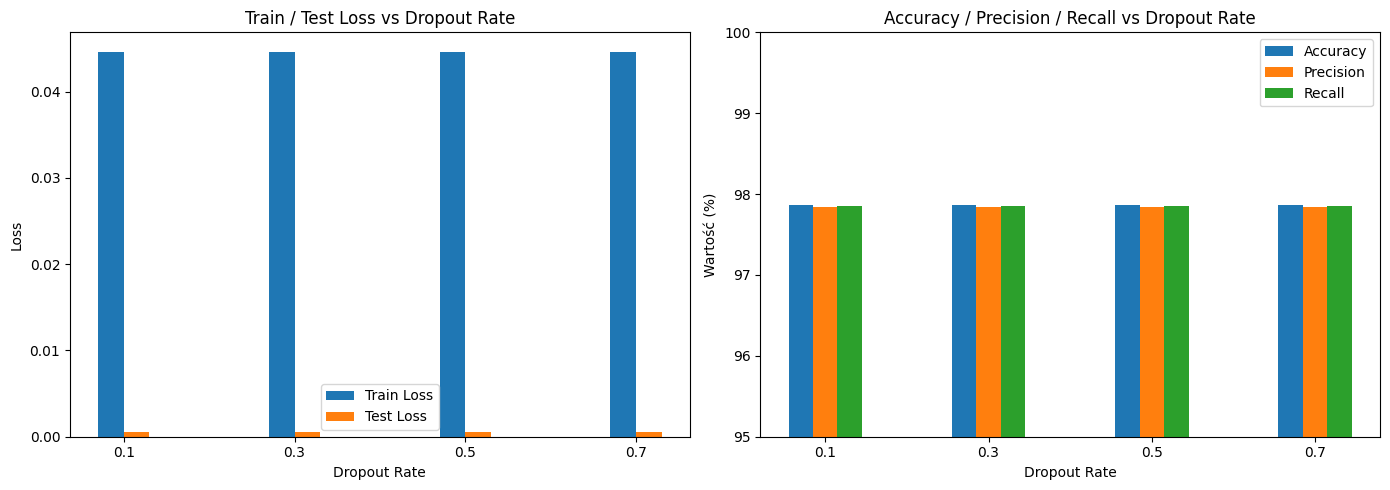

In [56]:
dropout_rates = list(results.keys())
train_losses = [results[dr]["train_loss"] for dr in dropout_rates]
test_losses  = [results[dr]["test_loss"] for dr in dropout_rates]
accuracies   = [results[dr]["accuracy"] for dr in dropout_rates]
precisions   = [results[dr]["precision"] for dr in dropout_rates]
recalls      = [results[dr]["recall"] for dr in dropout_rates]

x = np.arange(len(dropout_rates))
width = 0.15

plt.figure(figsize=(14,5))

# Accuracy / Precision / Recall
plt.subplot(1,2,2)
plt.bar(x - width, accuracies, width, label="Accuracy")
plt.bar(x, precisions, width, label="Precision")
plt.bar(x + width, recalls, width, label="Recall")
plt.xticks(x, dropout_rates)
plt.xlabel("Dropout Rate")
plt.ylabel("Wartość (%)")
plt.title("Accuracy / Precision / Recall vs Dropout Rate")
plt.legend()
plt.ylim(95, 100)

# Loss
plt.subplot(1,2,1)
plt.bar(x - width/2, train_losses, width, label="Train Loss")
plt.bar(x + width/2, test_losses, width, label="Test Loss")
plt.xticks(x, dropout_rates)
plt.xlabel("Dropout Rate")
plt.ylabel("Loss")
plt.title("Train / Test Loss vs Dropout Rate")
plt.legend()


plt.tight_layout()
plt.show()

Widać, że wyniki dla poszczególnych dropoutrate są do siebie bardzo zbliżone. Można wywnioskować, że wartości tego parametru nie ma tutaj ogromnego znaczenia, przynajmniej dla tej konkretnej sieci.

Na koniec sprawdzę czy dodanie BatchNorm (technika normalizacji danych w sieciach neuronowych w trakcie treningu) pozwoli ulepszyć wyniki modelu CNN1

In [58]:
class CNN1_BN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN1_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.bn2 = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d(dropout_rate)
        self.fc1 = nn.Linear(320, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        x = x.view(-1, 320)
        x = F.dropout(F.relu(self.bn3(self.fc1(x))), training=self.training)
        x = self.fc2(x)
        return x

Epoch 1/3 | Test loss: 0.0008 | Accuracy: 98.44% | Precision: 98.43% | Recall: 98.42%
Epoch 2/3 | Test loss: 0.0006 | Accuracy: 98.73% | Precision: 98.74% | Recall: 98.71%
Epoch 3/3 | Test loss: 0.0005 | Accuracy: 98.93% | Precision: 98.93% | Recall: 98.92%
 Parametry eksperymentu:
   n_epochs: 3
   batch_size: 64
   lr: 0.001
   optimizer_name: adam
   dropout_rate: 0.5

 Wyniki końcowe:
   Train Loss: 0.0392
   Test Loss:  0.0005
   Accuracy:   98.93%
   Precision:  98.93%
   Recall:     98.92%


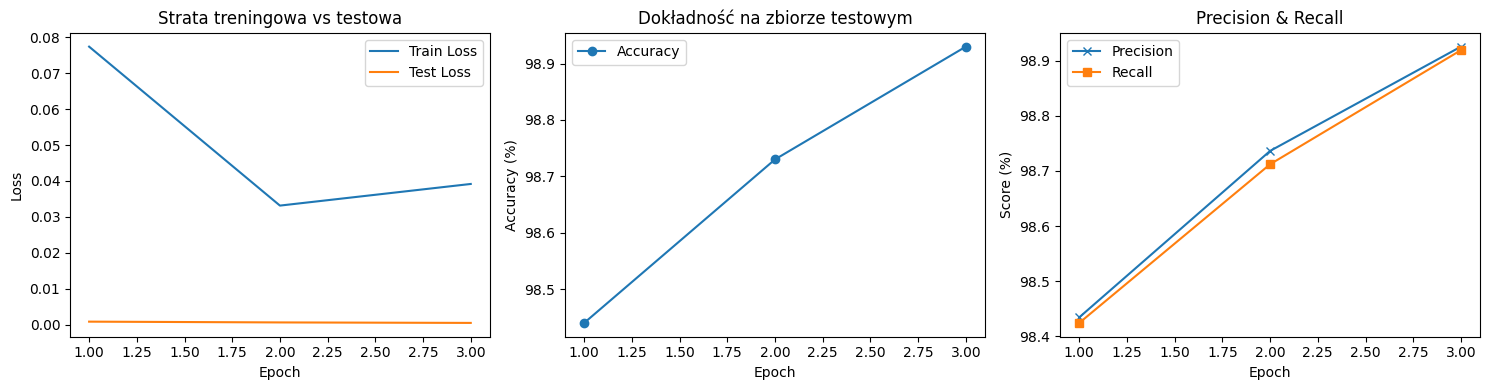


 Struktura modelu:
CNN1_BN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [61]:
params_BN = {
    "n_epochs": 3,
    "batch_size": 64,
    "lr": 0.001,
    "optimizer_name": "adam",
    "dropout_rate": 0.5,
}

modelBN, train_lossesBN, test_lossesBN, accuraciesBN,precisionsBN,recallsBN = run_experiment(
    CNN1_BN,
    **params_BN
)

analyze_results(modelBN, train_lossesBN, test_lossesBN, accuraciesBN,precisionsBN,recallsBN, params_BN)

Wizualizacja oraz porównanie

              Model  Accuracy (%)  Precision (%)  Recall (%)  Train Loss  \
0              CNN1         97.41      97.442238   97.402859    0.364152   
1  CNN1 z BatchNorm         98.44      98.434515   98.424389    0.077390   

   Test Loss  
0   0.001282  
1   0.000829  


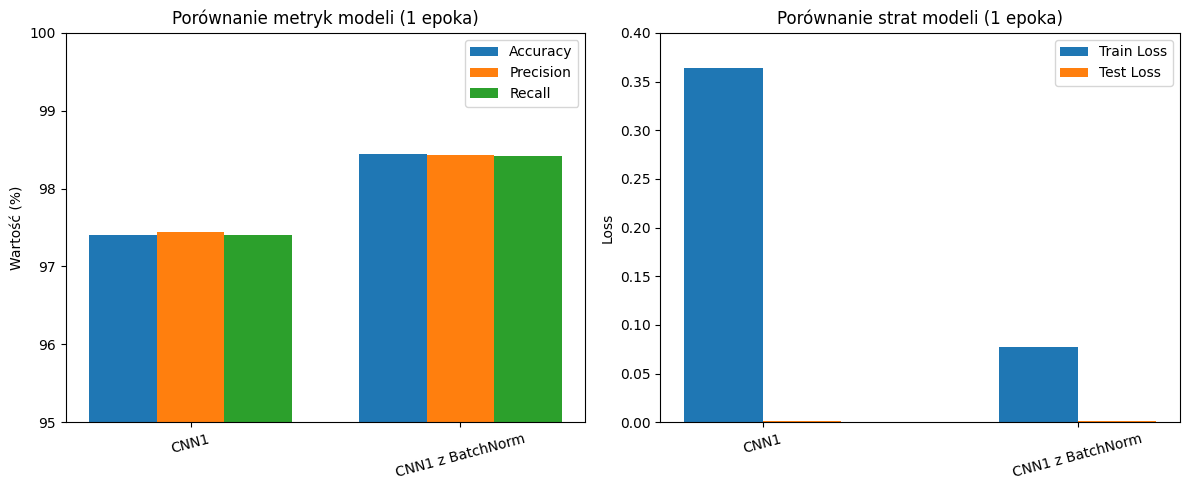

In [64]:
accs  = [accuracies1[0], accuraciesBN[0]]
precs = [precisions1[0], precisionsBN[0]]
recs  = [recalls1[0], recallsBN[0]]
train_losses = [train_losses1[0], train_lossesBN[0]]
test_losses  = [test_losses1[0], test_lossesBN[0]]

model_names = ["CNN1", "CNN1 z BatchNorm"]

df = pd.DataFrame({
    "Model": model_names,
    "Accuracy (%)": accs,
    "Precision (%)": precs,
    "Recall (%)": recs,
    "Train Loss": train_losses,
    "Test Loss": test_losses
})
print(df)

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(12,5))

#  Accuracy / Precision / Recall
plt.subplot(1,2,1)
plt.bar(x - width, accs, width, label="Accuracy")
plt.bar(x, precs, width, label="Precision")
plt.bar(x + width, recs, width, label="Recall")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Wartość (%)")
plt.title("Porównanie metryk modeli (1 epoka)")
plt.legend()
plt.ylim(95, 100)

#  Train vs Test Loss
plt.subplot(1,2,2)
plt.bar(x - width/2, train_losses, width, label="Train Loss")
plt.bar(x + width/2, test_losses, width, label="Test Loss")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Loss")
plt.title("Porównanie strat modeli (1 epoka)")
plt.legend()
plt.ylim(0.0, 0.40)

plt.tight_layout()
plt.show()

Wykresy pokazują, że dodanie BatchNorm zwiększa Accuracy, Precision oraz Recall sieci, a także znacząco zmniejszą TrainLoss

**Podsumowanie**

Testy pokazały, że dobór parametrów, funkcji, wartości parametrów itd. ma wpływ na wyniki modelu. Zmiana niektórych parametrów rezultuje w większych różnicach w wynikach modelu niż zmiana innych. Przy skutecznym i dobrym strukturowo modelu często będą to minimalne zmiany w metrykach końcowych.